In [27]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
normal_data = pd.read_json("normal.json")
chat_data = pd.read_json("chat.json")
group1_data = pd.read_json("clean-group-1.json")

spam_data = pd.read_json("spam.json")
spam_data2 = pd.read_json("spam2.json")
spam_data2_up = pd.read_json("spam2-up.json")

group1_df = pd.DataFrame({ 'type': 0, 'message': group1_data.iloc[:, 0] }) # (개인) 정상
normal_df = pd.DataFrame({ 'type': 0, 'message': normal_data.iloc[:, 0] }) # (경찰청) 광고
sampled_normal_df = normal_df.sample(n=5000, random_state=42)
chat_df = pd.DataFrame({ 'type': 0, 'message': chat_data.iloc[:, 0] }) # 한국어 멀티턴 대화
sampled_chat_df = chat_df.sample(n=5000, random_state=42)

spam_df = pd.DataFrame({ 'type': 1, 'message': spam_data.iloc[:4000, 0] }) # (경찰청) 스팸
spam2_df = pd.DataFrame({ 'type': 1, 'message': spam_data2.iloc[:, 0] }) # (개인) 스팸
spam2_up_df = pd.DataFrame({ 'type': 1, 'message': spam_data2_up.iloc[:, 0] }) # (개인) 스팸 증강

print(sampled_normal_df.shape[0])
print(sampled_chat_df.shape[0])
print(group1_df.shape[0])
print(spam_df.shape[0])
print(spam2_df.shape[0])

data = pd.concat([sampled_normal_df, sampled_chat_df, group1_df, spam_df, spam2_df, spam2_up_df], ignore_index=True)
#data = pd.concat([normal_df, chat_df, group1_df, spam_df, spam2_df, spam2_up_df], ignore_index=True)
data

5000
5000
1643
4000
435


,type,message
0,0,[ak플라자 수원]ak플라자 수원에 찾아온 크리스마스> http://m.akplaz...
1,0,"[kt] d- super flexday / (금) open!?금/토/일, 단 일 최..."
2,0,"향남 청년정육점 소잡는날!!육회, 사시미 예약받습니다!!육회 사시면 수제소스 증정!..."
3,0,"[skt] t 멤버십 vip 고객님 한정 tmap 대리 만 원 쿠폰 안내고객님, 안..."
4,0,hearts봉선동 대림 e-편한세상hearts 남구 교육 번지 no. 브랜드 광주 ...
...,...,...
18167,1,고객님으이 으인증번호는 1819 입니닷. http://dmm2o24.com/
18168,1,gaip 200% b0nus ev3nt 농구 매 쿼터 유럽형 kasino star ...
18169,1,무료 3만원 환.가.능 카 슬 스 미 다 o k https://u2.to/2kf4j...
18170,1,cashback햏사 카.지.노 2% 3플러스2 5플러스3 1플러스5 3플러스1 1플...


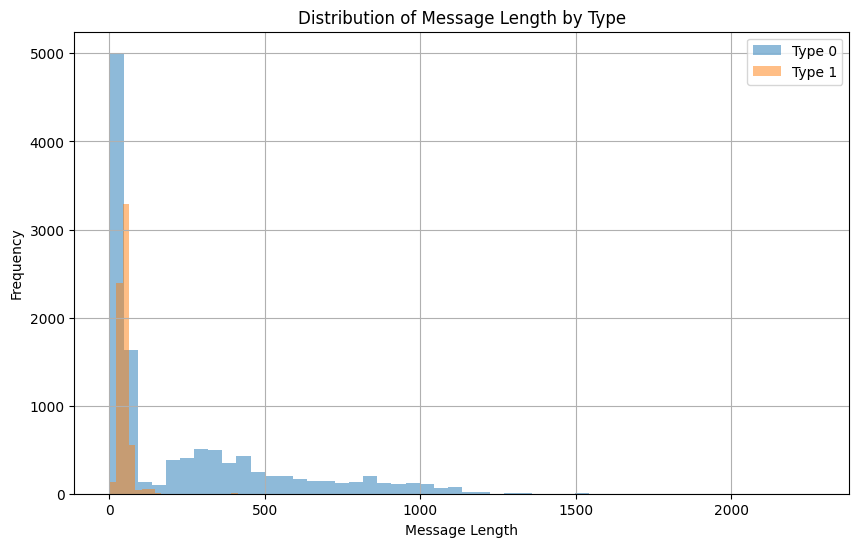

In [29]:
# Calculate the length of the message for each row
data['message_length'] = data['message'].apply(len)

# Separate data by type
data_type_0 = data[data['type'] == 0]
data_type_1 = data[data['type'] == 1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram for type 0
plt.hist(data_type_0['message_length'], bins=50, alpha=0.5, label='Type 0')

# Plot histogram for type 1
plt.hist(data_type_1['message_length'], bins=50, alpha=0.5, label='Type 1')

# Add title and labels
plt.title('Distribution of Message Length by Type')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [30]:
data.isnull().values.any()

np.False_

In [31]:
data['message'].nunique()

18162

<Axes: xlabel='type'>

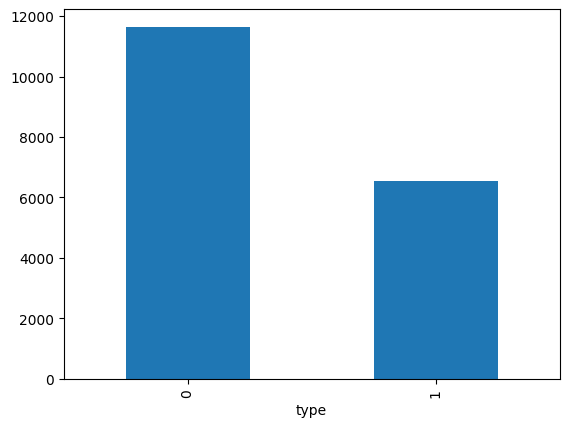

In [32]:
data['type'].value_counts().plot(kind='bar')

In [33]:
# 토큰화
from tqdm import tqdm
from kiwipiepy import Kiwi

kiwi = Kiwi(num_workers=32)
tqdm.pandas()

def get_tokens(text):
    if pd.isna(text) or not text:
        return []
    tokens = kiwi.tokenize(str(text))
    filtered_tokens = []
    for token in tokens:
        if token.tag[0] in ['N', 'V', 'M', 'S', 'U', 'W']:
            filtered_tokens.append(token.form)
    return filtered_tokens

data['tokens'] = data['message'].progress_apply(get_tokens)


100%|██████████| 18172/18172 [00:49<00:00, 370.63it/s] 


In [34]:
from sklearn.model_selection import train_test_split

X = data["tokens"]
y = data["type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame({'tokens': X_train, 'type': y_train})
train_df.to_json('dataset-train.json', orient='records', indent=4, force_ascii=False)

test_df = pd.DataFrame({'tokens': X_test, 'type': y_test})
test_df.to_json('dataset-test.json', orient='records', indent=4, force_ascii=False)


In [35]:
from tf_keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [36]:
threshold = 10
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32889
등장 빈도가 9번 이하인 희귀 단어의 수: 27510
단어 집합에서 희귀 단어의 비율: 83.64498768585241
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.465487836110419


In [37]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5380


In [38]:
# tokenizer
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [39]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)